<a href="https://colab.research.google.com/github/standard-aaron/deep-learning-projects/blob/main/pyro_amortization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 10.0 MB/s 


In [71]:
import numpy as np
import torch
from torch import nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Overview

In this notebook I'm working through a basic example of *amortized inference* via Pyro.

In this example, I'll simulate a matrix $X = (x_1, x_2, \ldots, x_n)^\intercal$, where $x_i$ is a vector of $K$ i.i.d. exponential r.v.s with parameter $\lambda_i$. When I simulate the data, $\lambda_i$ is selected from the range [1, 10]. 

In [140]:
K = 50 # The number of observations per row, all with shared $\lambda_i$
N = 1000 # The number of rows, each with a unique $\lambda_i$
def simulate_data(n=N):
  mu = np.linspace(1, 10, n)
  return torch.stack(
        [
            torch.tensor(np.random.exponential(mu_i, size=K), dtype=torch.float32)
            for mu_i in mu
        ]
  )
data = simulate_data()

In order to perform amortized inference, we need to specify an encoding module $g(x)$ that
maps from (potentially new, unseen) input data $x_i$ to predicted variational
parameters $\phi$.
The reason amortized inference is good is e.g. so that we don't have to
re-train the model
when new data arrives;
instead, we just *predict* the optimal variational parameters using
$g(x_i) = \hat{\phi^*}$.

In this example, our encoder $g(x)$ is a simple MLP with 1 hidden layer.

In [141]:
class Encoder(nn.Module):
  def __init__(self, hidden_dim=10):
      super().__init__()
      # setup the three linear transformations used
      self.fc1 = nn.Linear(K, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, 1)
      # setup the non-linearities
      self.softplus = nn.Softplus()

  def forward(self, x):
      hidden = self.softplus(self.fc1(x))
      z = self.softplus(self.fc2(hidden))
      return z

class MyVariationalModule(nn.Module):
  def __init__(self):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder()

  def model(self, data):
      with pyro.plate("data", dim=-2):
        mu = pyro.sample("mu", dist.Uniform(torch.zeros(data.shape), 100.0*torch.ones(data.shape)))
        pyro.sample("obs", dist.Exponential(mu), obs=data)

  # define the guide (i.e. variational distribution) q(z|x)
  def guide(self, data):
      # register PyTorch module `encoder` with Pyro
      pyro.module("encoder", self.encoder)
      # use the encoder to get the parameters used to define q(z|x)
      z = self.encoder(data)
      with pyro.plate("data", dim=-2):
        pyro.sample("mu", dist.Delta(z.expand(data.shape)))

In [142]:
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

v = MyVariationalModule()

# setup the inference algorithm
svi = SVI(v.model, v.guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
  loss = svi.step(data)
  if step % 50 == 0: 
    print(step, loss)


0 403585.46875
50 360727.1796875
100 359285.171875
150 358936.53125
200 358782.4375
250 358688.3125
300 358609.640625
350 358536.9375
400 358468.5859375
450 358402.9453125
500 358339.6171875
550 358278.6171875
600 358219.9765625
650 358162.4609375
700 358110.171875
750 358063.3984375
800 358021.703125
850 357984.9453125
900 357952.9140625
950 357925.34375
1000 357901.8046875
1050 357877.984375
1100 357854.9453125
1150 357840.359375
1200 357828.7421875
1250 357819.5390625
1300 357812.3046875
1350 357806.640625
1400 357802.21875
1450 357798.765625
1500 357796.0234375
1550 357793.8671875
1600 357792.125
1650 357790.703125
1700 357789.515625
1750 357788.5234375
1800 357787.6640625
1850 357786.9375
1900 357786.3046875
1950 357785.734375
2000 357785.234375
2050 357784.796875
2100 357784.40625
2150 357784.046875
2200 357783.734375
2250 357783.4765625
2300 357783.203125
2350 357782.9765625
2400 357782.765625
2450 357782.6328125
2500 357782.4140625
2550 357782.2578125
2600 357782.1015625
2650 3

Text(0.5, 1.0, 'Training set param estimates')

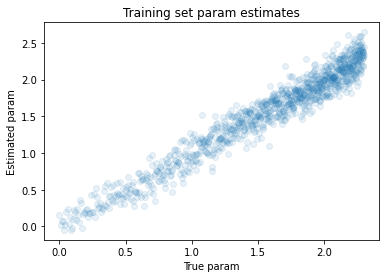

In [144]:
# Predicted mean parameters on the training data

mu = v.encoder(data)

plt.scatter(
    np.log(np.linspace(1, 10, N)),
    np.log(1/mu.detach().numpy()),
    alpha=0.1
)
plt.xlabel("True param")
plt.ylabel("Estimated param")
plt.title("Training set param estimates")

Text(0.5, 1.0, 'Holdout set param estimates')

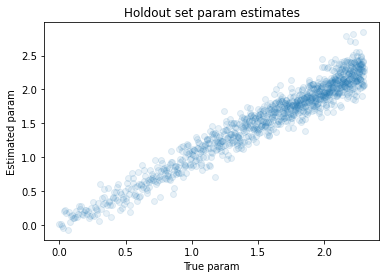

In [145]:
# Compare to holdout data estimates

data_holdout = simulate_data()

with torch.no_grad():
  mu_holdout = v.encoder(data_holdout)

plt.scatter(
    np.log(np.linspace(1, 10, N)),
    np.log(1/mu_holdout.detach().numpy()),
    alpha=0.1
)
plt.xlabel("True param")
plt.ylabel("Estimated param")
plt.title("Holdout set param estimates")